# Funciones de activación

## Qué es una función de activación?

Sin entrar en una definición formal, una función de activación es aquella que se usa en un contexto de redes neuronales para encapsular cada una de las neuronas. El encapsular cada neurona se hace para modular el resultado que esta nos arroja, por ejemplos, si necesitamos que el resultado de una neurona este entre 0 y 1 podríamos encapsular el resultado de esta neurona con una función de Sigmoid (Que oportunamente nos da un resultado entre 0 y 1). ¿Porque podríamos querer tal resultado? Supongamos que vamos a usar el resultado para clasificar un elemento entre dos grupos (Clasificación binaria), si el resultado es menor a 0.5 (< 0.5) lo clasifico en un grupo y si el resultado es mayor o igual a 0.5 (>= 0.5) lo clasifico en el otro.

$$g(f(x))\space=\space Funcion\space de\space activacion\space(Resultado\space de \space neurona(x))$$

## Qué vamos a ver con este modelo?

Vamos a establecer un valor como target, nuestro objetivo va a ser a partir de un dataset (x) ajustar nuestras variables (a,b), en un contexto de una función de activación, de forma que obtengamos este valor que seleccionamos como target. Esto lo vamos a implementar usando TensorFlow. Además, Vamos a preparar la Notebook para correr el modelo por CPU o GPU a elección

Vamos a comparar 4 funciones de activación distintas con el fin de ver que tan bien convergen en el contexto de nuestro modelo. 
* Dos que se usan para modelos de clasificación: Sigmoid y Tangente Hiperbólica
* Dos que se usan para modelos con un resultado continuo: ReLU (Unidad Lineal Rectificada) y ELU (Unidad lineal exponencial)

Más abajo tenemos una definición matemática breve para cada una.

## Qué es TensorFlow?

Es una librería open-source desarrollada por Google que nos permite (De forma muy resumida) hacer uso de grafos y tensores para construir y entrenar redes neuronales. Aclaramos:
* Un tensor es el principal bloque de datos que usa TensorFlow, cada tensor tiene una dimensión y un tipo. Respecto a las dimensiones un tensor puede ser, por ejemplo, unidimensional (vector), bidimensional (Matriz) o Tridimensional (Matriz en 3D). Y respecto al tipo, se refiere al tipo de dato que contiene, por ejemplo, un float32 que es un dato numérico que ocupa 32 bits.
* Los grafos son conjuntos de nodos conectados entre sí a través de aristas o arcos, que representan relaciones entre elementos de un conjunto. Estos nodos, arcos y aristas representan constantes, variables, placeholder, operaciones aritméticas, etc.

<img src="./Grafo.png">

## Cómo funciona el modelo?

1) Vamos a generar nuestras variables (a,b), un par para cada función de activación, estos son los elementos que vamos a ir ajustando con las sucesivas iteración con el fin de obtener como salida nuestro valor objetivo. Además, definimos nuestros placeholders, como el nombre indica son tensores que nos guardan el lugar para los elementos de nuestro dataset. Y por último generamos nuestro dataset, en este caso por medio de una distribución normal indicando la media, el desvío y la cantidad de elementos a generar.

2) Definimos cada una de nuestras funciones de activación.

3) Definimos la función de perdida para cada caso.

4) Definimos el algoritmo de optimización (gradiente descendente) y se lo aplicamos a cada una de las funciones de activación indicando que buscamos minimizar el resultado de la función de perdida. Indicamos la cuota de aprendizaje.

5) Entrenamos el modelos para ajustar las variables indicando la cantidad de iteraciones que deseamos realizar y la cantidad de elementos que vamos a usar en cada iteración.

6) Evaluamos el resultado.

### Librerias 

In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

### Configuración GPU - CPU 

Aclaramos que no necesariamente el correr este modelo por GPU da un menor tiempo de procesamiento por el hecho que no estamos computando calculos que requieren de mucha potencia computacional.

Con esta función abajo pueden ver que componentes tiene su computadora que nos permita entrenar el modelo, puede ser por GPU o CPU.

In [2]:
devices = device_lib.list_local_devices() 
for device in devices:
    print(device)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17813739061612595733

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6618563871
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11246073792460443536
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"



Abajo configuro si voy a correr el modelo por medio del GPU o CPU. Voy a dejarlo preparado para correrlo por GPU, pero si se pretende correr este mismo modelo por CPU habría que modificar la primera linea de la celda:

config = tf.ConfigProto(log_device_placement=True,device_count = {'GPU': 0})

Modifico el -1 por 0, lo que le estoy indicando es que no use el GPU.

Al final esta función nos indica los detalles del GPU si se corrio con GPU o queda en blanco si se corrio con CPU

In [3]:
config = tf.ConfigProto(log_device_placement=True,device_count = {'GPU': -1})
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

session = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



### Panel 

Este es nuestro "Panel" con el cual podemos ir modificando distintos parametros del modelo para jugar con ellos y ver que resultado nos arroja.

Cuando modifiquemos el valor objetivo tengamos en cuenta el dominio de cada función de activación, más abajo estan indicados, si nos salimos del rango de dominio de una función de activación esta no va a poder ajustarse a nuestro target.

In [4]:
#Cantidad de datos generados
Dataset_size = 1000

#Parametros de la distribución normal
mean = 0
std = 2

#Nuestro valor objetivo
target = 0.8

#Cuota de aprendizaje del algoritmo de optimización de Gradiente descendente (Learning rate)
learning_rate = 0.01

#Cantidad de iteraciones y cantidad de datos usados para iterar
iteration = 8000
batch_size = 50

In [5]:
a1 = tf.Variable(tf.random_normal(shape=[1,1]))
b1 = tf.Variable(tf.random_normal(shape=[1,1]))
a2 = tf.Variable(tf.random_normal(shape=[1,1]))
b2 = tf.Variable(tf.random_normal(shape=[1,1]))
a3 = tf.Variable(tf.random_normal(shape=[1,1]))
b3 = tf.Variable(tf.random_normal(shape=[1,1]))
a4 = tf.Variable(tf.random_normal(shape=[1,1]))
b4 = tf.Variable(tf.random_normal(shape=[1,1]))

x = np.random.normal(loc=mean, scale=std, size=Dataset_size)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)

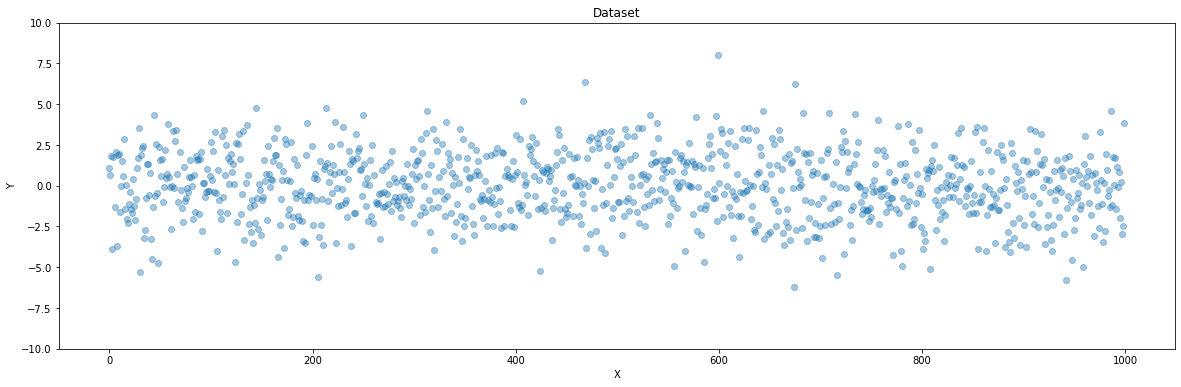

In [6]:
plt.figure(1,figsize=(20,6))
plt.scatter(x=list(range(0,len(x))),y=x,alpha=0.4)
plt.ylim(mean-5*std,mean+5*std)
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Funciones de activación

### Sigmoide 
$$sigmoid(x) = \sigma(x) = \frac{1}{1+e^{a\cdot x+b}} $$

$$Output = (0,1)$$

In [7]:
sigmoid_act = tf.sigmoid(tf.add(tf.matmul(x_data,a1),b1))

### ReLU
$$ReLU(x)=max(0,a\cdot x+b)$$

$$Output = (0,\infty)$$

In [8]:
relu_act = tf.nn.relu(tf.add(tf.matmul(x_data,a2),b2))

### Tangente hiperbolico
$$tangh(x)=\frac{e^{a\cdot x+b}-e^{-(a\cdot x+b)}}{e^{a\cdot x+b}+e^{-(a\cdot x+b)}}$$

$$Output = (-1,1)$$

In [9]:
tangh_act = tf.tanh(tf.add(tf.matmul(x_data,a3),b3))

### ELU
$$ELU(x)=\space when\space x<0\space then\space e^{a\cdot x+b}+1$$
$$ else\space a\cdot x+b$$

$$Output = (-1,\infty)$$

In [10]:
elu_act = tf.nn.elu(tf.add(tf.matmul(x_data,a4),b4))

## Funciones de perdida

In [11]:
loss_sigmoid = tf.reduce_mean(tf.square(tf.subtract(sigmoid_act, target)))
loss_relu    = tf.reduce_mean(tf.square(tf.subtract(relu_act, target)))
loss_elu     = tf.reduce_mean(tf.square(tf.subtract(elu_act, target)))
loss_tangh   = tf.reduce_mean(tf.square(tf.subtract(tangh_act, target)))

## Función de optimización y aplicación

In [12]:
my_optim = tf.train.GradientDescentOptimizer(learning_rate)

train_step_sigmoid = my_optim.minimize(loss_sigmoid)
train_step_relu    = my_optim.minimize(loss_relu)
train_step_elu     = my_optim.minimize(loss_elu)
train_step_tangh   = my_optim.minimize(loss_tangh)

## Inicializamos las variables

In [13]:
init = tf.global_variables_initializer()
session.run(init)

## Entrenamos el modelo

In [14]:
loss_vec_sigmoid=[]
loss_vec_relu=[]
loss_vec_elu=[]
loss_vec_tangh=[]
act_sigmoid=[]
act_relu=[]
act_elu=[]
act_tangh=[]
t_base=time.time()
for i in range(iteration):
    rand_idx = np.random.choice(len(x),size=batch_size)
    x_vals = np.transpose([x[rand_idx]])
    
    session.run(train_step_sigmoid,feed_dict={x_data:x_vals})
    session.run(train_step_relu,feed_dict={x_data:x_vals})
    session.run(train_step_elu,feed_dict={x_data:x_vals})
    session.run(train_step_tangh,feed_dict={x_data:x_vals})
    
    loss_vec_sigmoid.append(session.run(loss_sigmoid,feed_dict={x_data:x_vals}))
    loss_vec_relu.append(session.run(loss_relu,feed_dict={x_data:x_vals}))
    loss_vec_elu.append(session.run(loss_elu,feed_dict={x_data:x_vals}))
    loss_vec_tangh.append(session.run(loss_tangh,feed_dict={x_data:x_vals}))
    
    act_sigmoid.append(np.mean(session.run(sigmoid_act,feed_dict={x_data:x_vals})))
    act_relu.append(np.mean(session.run(relu_act,feed_dict={x_data:x_vals})))
    act_elu.append(np.mean(session.run(elu_act,feed_dict={x_data:x_vals})))
    act_tangh.append(np.mean(session.run(tangh_act,feed_dict={x_data:x_vals})))
    
t_1=time.time()
print('El procesamiento tardo %f segundos'%(t_1-t_base))

El procesamiento tardo 36.240193 segundos


## Analizamos convergencia

En el análisis vamos a poder ver cuantas iteraciones tardo cada caso en converger al valor esperado, como se comportó la función de perdida para cada caso y que resultados finales obtuvimos.

Aunque en este caso vemos que algunas funciones convergen más rápido que otras no debemos de sacar la conclusión de que estas son las mejores, según cada caso, que objetivo tenemos, que red neuronal estamos armando, etc. podemos usar diferentes funciones de activación, no depende solamente de la velocidad de convergencia. Al margen, podemos combinar las funciones de activación dentro de una red neuronal, las redes están compuestas (usualmente) por varios layer, cada layer puede tener una función de activación diferente.

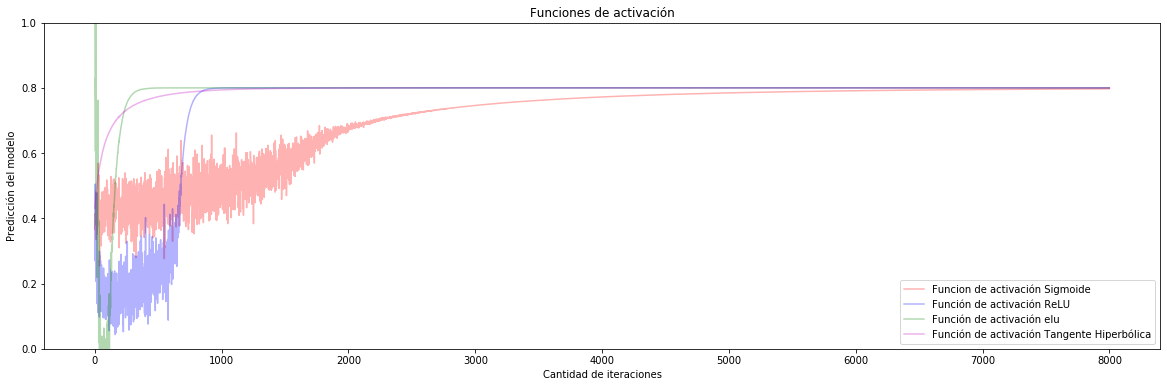

In [15]:
plt.figure(figsize=(20,6))
plt.plot(act_sigmoid, 'r-', label='Funcion de activación Sigmoide', alpha=0.3)
plt.plot(act_relu, 'b-', label='Función de activación ReLU', alpha=0.3)
plt.plot(act_elu, 'g-', label='Función de activación elu', alpha=0.3)
plt.plot(act_tangh, 'm-', label='Función de activación Tangente Hiperbólica', alpha=0.3)
plt.ylim(0.0,1.0)
plt.title('Funciones de activación')
plt.ylabel('Predicción del modelo')
plt.xlabel('Cantidad de iteraciones')
plt.legend(loc='lower right')
plt.show()

#### Iteraciones de 0 a 1000

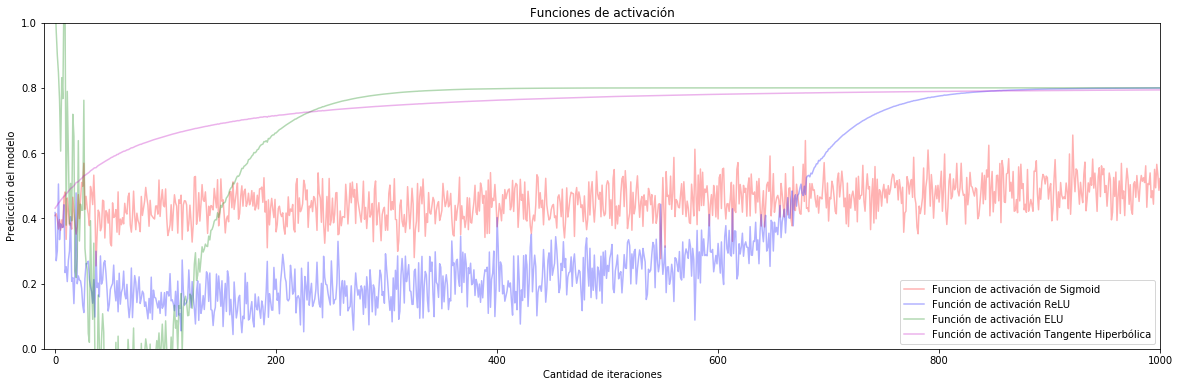

In [16]:
plt.figure(figsize=(20,6))
plt.plot(act_sigmoid, 'r-', label='Funcion de activación de Sigmoid', alpha=0.3)
plt.plot(act_relu, 'b-', label='Función de activación ReLU', alpha=0.3)
plt.plot(act_elu, 'g-', label='Función de activación ELU', alpha=0.3)
plt.plot(act_tangh, 'm-', label='Función de activación Tangente Hiperbólica', alpha=0.3)
plt.ylim(0.0,1.0)
plt.xlim(-10,1000)
plt.title('Funciones de activación')
plt.ylabel('Predicción del modelo')
plt.xlabel('Cantidad de iteraciones')
plt.legend(loc='lower right')
plt.show()

In [17]:
print('Resultado según Sigmoid: %f'%act_sigmoid[-1])
print('Resultado según ReLU: %f'%act_relu[-1])
print('Resultado según ELU: %f'%act_elu[-1])
print('Resultado según Tangente Hiperbólica: %f'%act_tangh[-1])

Resultado según Sigmoid: 0.796965
Resultado según ReLU: 0.799999
Resultado según ELU: 0.799999
Resultado según Tangente hiperbolica: 0.799992


## Analizamos perdida

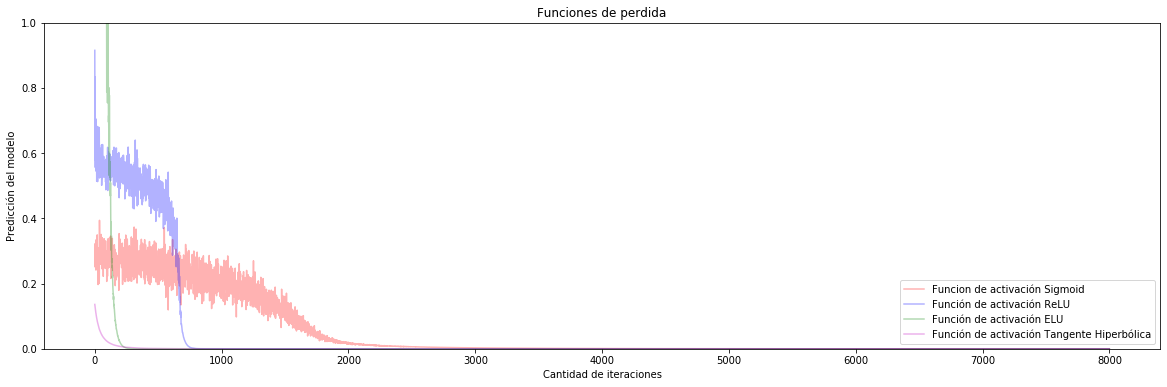

In [18]:
plt.figure(figsize=(20,6))
plt.plot(loss_vec_sigmoid, 'r-', label='Funcion de activación Sigmoid', alpha=0.3)
plt.plot(loss_vec_relu, 'b-', label='Función de activación ReLU', alpha=0.3)
plt.plot(loss_vec_elu, 'g-', label='Función de activación ELU', alpha=0.3)
plt.plot(loss_vec_tangh, 'm-', label='Función de activación Tangente Hiperbólica', alpha=0.3)
plt.ylim(0.0,1.0)
plt.title('Funciones de perdida')
plt.ylabel('Predicción del modelo')
plt.xlabel('Cantidad de iteraciones')
plt.legend(loc='lower right')
plt.show()

#### Iteraciones de 0 a 1000

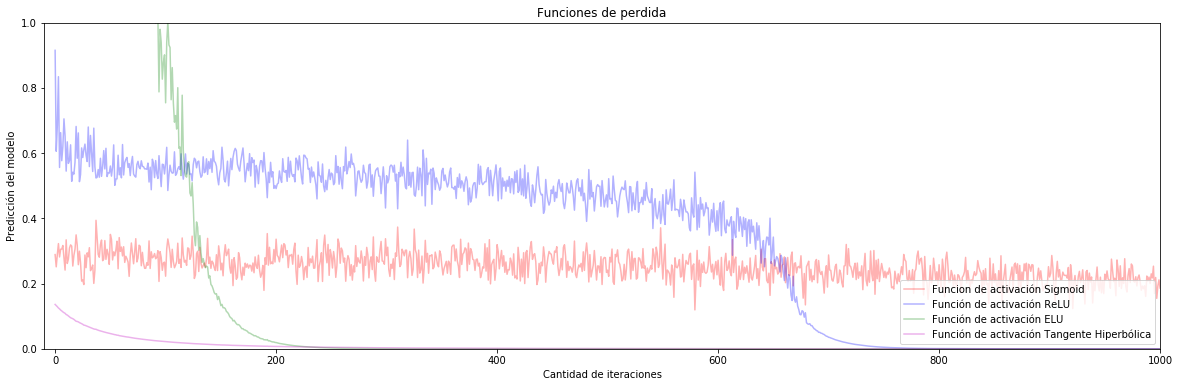

In [19]:
plt.figure(figsize=(20,6))
plt.plot(loss_vec_sigmoid, 'r-', label='Funcion de activación Sigmoid', alpha=0.3)
plt.plot(loss_vec_relu, 'b-', label='Función de activación ReLU', alpha=0.3)
plt.plot(loss_vec_elu, 'g-', label='Función de activación ELU', alpha=0.3)
plt.plot(loss_vec_tangh, 'm-', label='Función de activación Tangente Hiperbólica', alpha=0.3)
plt.ylim(0.0,1.0)
plt.xlim(-10,1000)
plt.title('Funciones de perdida')
plt.ylabel('Predicción del modelo')
plt.xlabel('Cantidad de iteraciones')
plt.legend(loc='lower right')
plt.show()

In [20]:
print('Ultimo resultado de la función de perdida de Sigmoid: %f'%loss_vec_sigmoid[-1])
print('Ultimo resultado de la función de perdida de ReLU: %f'%loss_vec_relu[-1])
print('Ultimo resultado de la función de perdida de ELU: %f'%loss_vec_elu[-1])
print('Ultimo resultado de la función de perdida de Tangente Hiperbólica: %f'%loss_vec_tangh[-1])

Ultimo resultado de la función de perdida de Sigmoid: 0.000009
Ultimo resultado de la función de perdida de ReLU: 0.000000
Ultimo resultado de la función de perdida de ELU: 0.000000
Ultimo resultado de la función de perdida de Tangente Hiperbólica: 0.000000
